Introduction

In this post, I’ll summarize the exploratory data analyses I performed, explain the feature engineering and reduction steps I utilized, and present my final models to classify tweets feed

Problem Statement
The goal of this project was to classify twitter feeds into breakfast time, lunch time or dinner time, using only features derived from text from ten news organizations

Data Acquisition
The first step of this project is to acquire live and historical twitter feeds via twitter API and store them as they are collected and use them to build my corpus. I wrote a function to collect 3,200 tweets at once(which is the limit per news organization). These data are stored as a csv file before processing and analysis in Pandas.


Risks and Assumptions
I’ve chosen my source based on some renowned news organizations and large corpus, but I recognize that these models may not generalize to news from other sources. Also it looks hard to differentiate classes out of my determined timeframe. The time interval I’m utilizing tweets is October 2017 onwards.

In [1]:
import twitter, re, datetime, pandas as pd, numpy as np
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import textblob
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier,AdaBoostRegressor,RandomForestRegressor,RandomForestClassifier,GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
import xgboost as xgb
from xgboost.sklearn import XGBClassifier  
from xgboost.sklearn import XGBRegressor
from sklearn.svm import SVC

//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import twitter, re, datetime, pandas as pd

# your keys go here:
twitter_keys = {
    'consumer_key':        'c2OWXk5ysfZHebnj7YQcKeVtR',
    'consumer_secret':     'qECxF7fUrC0AFi4Ib7ye4dXlqFcJxbADox4z5xh9CSuRWbYugA',
    'access_token_key':    '930174555032825862-cg1AJLOXuE61kTxYtrcwPN53czHhNby',
    'access_token_secret': '4fRMZkII1IeZGY8VDEFqKuO12SDmtHEfj4aqnGJHCdG7Y'
}

api = twitter.Api(
    consumer_key         =   twitter_keys['consumer_key'],
    consumer_secret      =   twitter_keys['consumer_secret'],
    access_token_key     =   twitter_keys['access_token_key'],
    access_token_secret  =   twitter_keys['access_token_secret']
)

In [3]:
class TweetMiner(object):

    result_limit    =   20    
    api             =   False
    data            =   []
    
    def __init__(self, keys_dict, api, result_limit = 20):
        
        self.api = api
        self.twitter_keys = keys_dict
        
        self.result_limit = result_limit
        

    def mine_user_tweets(self, user="GA", mine_rewteets=False, max_id=None):

        data           =  []
        last_tweet_id  =  False

        
            
        statuses   =   self.api.GetUserTimeline(screen_name=user, count=self.result_limit, max_id=max_id)        
                
        for item in statuses:

            mined = {
            'tweet_id': item.id,
            'handle': item.user.name,
            'retweet_count': item.retweet_count,
            'text': item.text,
            'mined_at': datetime.datetime.now(),
            'created_at': item.created_at,
        }


            data.append(mined)
                
            
        return data

In [4]:
miner = TweetMiner(keys_dict = twitter_keys, api = api, result_limit=200) 

In [5]:
cnn_tweets = miner.mine_user_tweets(user='CNN')
cnn_df2= pd.DataFrame(cnn_tweets)
cnn_df2

,created_at,handle,mined_at,retweet_count,text,tweet_id
0,Tue Dec 19 17:10:02 +0000 2017,CNN,2017-12-19 12:17:06.988705,159,A video capturing an unidentified object flyin...,943166546779578371
1,Tue Dec 19 17:03:00 +0000 2017,CNN,2017-12-19 12:17:06.988714,51,Here are five things you need to know about Tr...,943164776892465157
2,Tue Dec 19 17:00:03 +0000 2017,CNN,2017-12-19 12:17:06.988716,46,The Hall of Presidents at the Magic Kingdom Pa...,943164034433523714
3,Tue Dec 19 16:50:09 +0000 2017,CNN,2017-12-19 12:17:06.988718,79,"The Winter Olympics, a royal wedding and reall...",943161540945072128
4,Tue Dec 19 16:40:11 +0000 2017,CNN,2017-12-19 12:17:06.988720,55,Atlanta is a top pick to host Amazon's second ...,943159032638033921
5,Tue Dec 19 16:30:10 +0000 2017,CNN,2017-12-19 12:17:06.988722,77,President Trump disputes a Washington Post sto...,943156511953555457
6,Tue Dec 19 16:20:05 +0000 2017,CNN,2017-12-19 12:17:06.988724,76,White House national security adviser H.R. McM...,943153978052956160
7,Tue Dec 19 16:10:14 +0000 2017,CNN,2017-12-19 12:17:06.988725,248,John Legend cast as Jesus Christ in upcoming N...,943151497407291393
8,Tue Dec 19 16:00:08 +0000 2017,CNN,2017-12-19 12:17:06.988727,474,"House Speaker Paul Ryan says he has ""no concer...",943148956376293376
9,Tue Dec 19 15:54:31 +0000 2017,CNN,2017-12-19 12:17:06.988729,161,McDonald's plans to start selling a McVegan bu...,943147542019264513


In [6]:
newmaxid = 942755009342705664

In [7]:
#adds to existing df called cnn_df
for _ in range(0,15):
    w_tweets = miner.mine_user_tweets(user='CNN',max_id=newmaxid)
    w_dfx = pd.DataFrame(w_tweets)
    cnn_df2  = pd.concat([cnn_df2, w_dfx])
    newmaxid =  cnn_df2.tweet_id.min() - 1

In [8]:
 cnn_df2.shape

(3200, 6)

In [9]:
twitter_final = pd.read_csv('twitter_final.csv')

In [10]:
twitter_final.shape

(32061, 6)

In [11]:
twitter_final.drop_duplicates('text').shape

(32000, 6)

In [16]:
twitter_final2 = twitter_final.copy()

In [17]:
twitter_final2 =twitter_final2.drop_duplicates('text')

In [18]:
twitter_final2.head()

,created_at,handle,mined_at,retweet_count,text,tweet_id
0,Tue Dec 19 15:54:31 +0000 2017,CNN,2017-12-19 10:55:00.628118,4,McDonald's plans to start selling a McVegan bu...,943147542019264513
1,Tue Dec 19 15:49:11 +0000 2017,CNN,2017-12-19 10:55:00.628128,50,K-pop fans are mourning the death of SHINee si...,943146199296724993
2,Tue Dec 19 15:35:08 +0000 2017,CNN,2017-12-19 10:55:00.628130,97,The Amtrak train that derailed Monday in Washi...,943142664379293696
3,Tue Dec 19 15:26:26 +0000 2017,CNN,2017-12-19 10:55:00.628132,45,House GOP leadership speaks ahead of today’s e...,943140475355193345
4,Tue Dec 19 15:20:16 +0000 2017,CNN,2017-12-19 10:55:00.628133,104,7 reasons why Republicans may have made a bad ...,943138921264926720


In [20]:
import os
import re
import csv
import sys
# In this next script, we’ll first clean up our dirty data, get rid of emoticons, hashtags, RT’s, ?, http, etc.
def process_text2(tweets):
        """Remove emoticons, numbers etc. and returns list of cleaned tweets."""
        stripped_text = [
        re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?" +
               sys.argv[1].lower(), '',
               tweets.lower()).strip()
    ]
        return stripped_text[0]


twitter_final2['Text'] =twitter_final2['text'].apply(process_text2) 

In [21]:
def remove_stop_words(tweets):
    """Remove stop words in tweets."""
    from nltk.corpus import stopwords
    stop = stopwords.words('english') 
    # If our word is not in the stop list then we add it to our word list
    clean_text = ' '.join([word for word in tweets.split(' ')
                           if word not in stop])
    return clean_text

twitter_final2['Text'] =twitter_final2['Text'].apply(remove_stop_words) 

In [22]:
def time(cell):
    if 6 <=int(cell[11:13]) < 9:
        return 'breakfast'
    elif 12 <=int(cell[11:13])< 14:
        return 'lunchtime'
    elif 18 <=int(cell[11:13])< 20:
        return 'dinnertime'
    else:
        return 'N/A'
    
twitter_final2['Time'] =twitter_final2['created_at'].apply(time)

In [23]:
def time2(cell):
    if cell =='breakfast':
        return 1
    elif cell =='lunchtime':
        return 2
    elif cell =='dinnertime':
        return 3
    else:
        return 4
    

In [24]:
twitter_final2['numeric_time']=twitter_final2['Time'].apply(time2)

In [25]:
twitter_final2.head(2)

,created_at,handle,mined_at,retweet_count,text,tweet_id,Text,Time,numeric_time
0,Tue Dec 19 15:54:31 +0000 2017,CNN,2017-12-19 10:55:00.628118,4,McDonald's plans to start selling a McVegan bu...,943147542019264513,mcdonalds plans start selling mcvegan burger h...,N/A,4
1,Tue Dec 19 15:49:11 +0000 2017,CNN,2017-12-19 10:55:00.628128,50,K-pop fans are mourning the death of SHINee si...,943146199296724993,kpop fans mourning death shinee singer kim jon...,N/A,4


In [26]:
twitter_final2.numeric_time.value_counts()

4    23794
3     3748
2     2443
1     2015
Name: numeric_time, dtype: int64

In [27]:
twitter_final2.handle.value_counts()

CNN                   3242
ABC News              3199
CBS Tweet             3199
Washington Post       3199
The New York Times    3198
MSNBC                 3198
WSB-TV                3196
Fox News              3193
BuzzFeed News         3189
MNPR | Ryan May       3187
Name: handle, dtype: int64

In [28]:
# engineering sentiment features for analysis
from textblob import TextBlob
def add_sub_and_pol(df):
    df=df.copy()
    def polarity(text):
        text = TextBlob(text)
        return text.sentiment.polarity
    
    def subjectivity(text):
        text = TextBlob(text)
        return text.sentiment.subjectivity
    
    def get_tweet_sentiment(text):
        text = TextBlob(text)
        if text.sentiment.polarity > 0:
            return 'positive'
        elif text.sentiment.polarity == 0:
            return 'neutral'
        else:
            return 'negative'
    twitter_final2['subjectivity'] =twitter_final2['Text'].apply(subjectivity)
    twitter_final2['polarity'] =twitter_final2['Text'].apply(polarity)
    twitter_final2['sentiment'] =twitter_final2['Text'].apply(get_tweet_sentiment)
    return twitter_final2.copy()

In [29]:
twitter_final2=add_sub_and_pol(twitter_final2)

In [30]:
twitter_final2.head()

,created_at,handle,mined_at,retweet_count,text,tweet_id,Text,Time,numeric_time,subjectivity,polarity,sentiment
0,Tue Dec 19 15:54:31 +0000 2017,CNN,2017-12-19 10:55:00.628118,4,McDonald's plans to start selling a McVegan bu...,943147542019264513,mcdonalds plans start selling mcvegan burger h...,N/A,4,0.000000,0.000000,neutral
1,Tue Dec 19 15:49:11 +0000 2017,CNN,2017-12-19 10:55:00.628128,50,K-pop fans are mourning the death of SHINee si...,943146199296724993,kpop fans mourning death shinee singer kim jon...,N/A,4,0.350000,0.050000,positive
2,Tue Dec 19 15:35:08 +0000 2017,CNN,2017-12-19 10:55:00.628130,97,The Amtrak train that derailed Monday in Washi...,943142664379293696,amtrak train derailed monday washington state ...,N/A,4,0.000000,0.000000,neutral
3,Tue Dec 19 15:26:26 +0000 2017,CNN,2017-12-19 10:55:00.628132,45,House GOP leadership speaks ahead of today’s e...,943140475355193345,house gop leadership speaks ahead todays expec...,N/A,4,0.450000,0.018182,positive
4,Tue Dec 19 15:20:16 +0000 2017,CNN,2017-12-19 10:55:00.628133,104,7 reasons why Republicans may have made a bad ...,943138921264926720,7 reasons republicans may made bad bet tax bil...,N/A,4,0.666667,-0.700000,negative


In [31]:
twitter_final2.to_csv('twitter_final2.csv', index=False)

In [32]:
twitter_final2 = pd.read_csv('twitter_final2.csv')

In [33]:
twitter_final2.Text.isnull().sum()

40

In [34]:
twitter_final2.shape

(32000, 12)

### Sentiment analysis

In [35]:
print('CBS happiness:',twitter_final2.loc[twitter_final2['handle'].str.contains('CBS Tweet'),'polarity'].mean())

print('WAPO happiness:', twitter_final2.loc[twitter_final2['handle'].str.contains('Washington Post'),'polarity'].mean())

print('MSNBC happiness:', twitter_final2.loc[twitter_final2['handle'].str.contains('MSNBC'),'polarity'].mean())

print('BuzzFeed happiness:', twitter_final2.loc[twitter_final2['handle'].str.contains('BuzzFeed News'),'polarity'].mean())

print('ABC happiness:',twitter_final2.loc[twitter_final2['handle'].str.contains('ABC News'),'polarity'].mean())

print('Fox News happiness:', twitter_final2.loc[twitter_final2['handle'].str.contains('Fox News'),'polarity'].mean())

print('CNN happiness:', twitter_final2.loc[twitter_final2['handle'].str.contains('CNN'),'polarity'].mean())

print('WSB-TV happiness:',twitter_final2.loc[twitter_final2['handle'].str.contains('WSB-TV'),'polarity'].mean())

print('NPR happiness:', twitter_final2.loc[twitter_final2['handle'].str.contains('MNPR'),'polarity'].mean())

print('NyTimes happiness:', twitter_final2.loc[twitter_final2['handle'].str.contains('New York Times'),'polarity'].mean())

CBS happiness: 0.13449295773576783
WAPO happiness: 0.03825815879875743
MSNBC happiness: 0.03547035789413839
BuzzFeed happiness: 0.058802152557208796
ABC happiness: 0.07244842193396407
Fox News happiness: 0.04745027704313646
CNN happiness: 0.03468648575874054
WSB-TV happiness: 0.07715688041012624
NPR happiness: 0.12366669934209873
NyTimes happiness: 0.08152966293718297


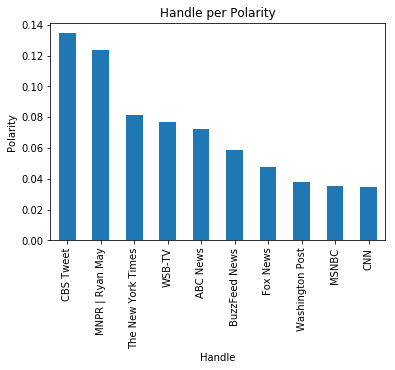

In [36]:
twitter_final2.groupby('handle')['polarity'].mean().sort_values(ascending=False).plot(kind='bar',title='Handle per Polarity')
plt.xlabel('Handle')
plt.ylabel('Polarity');

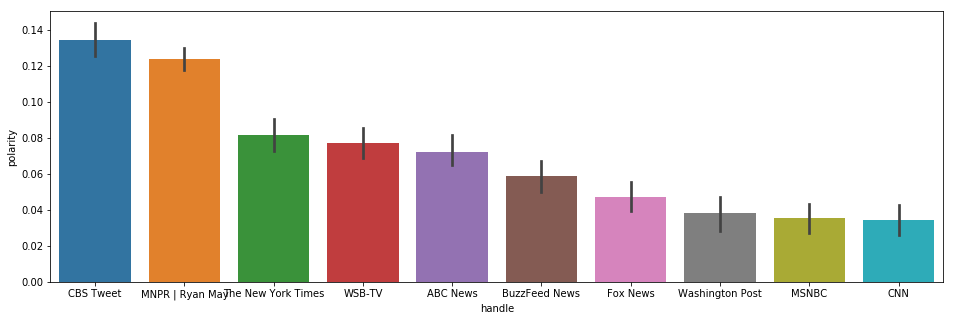

In [38]:
order_of_polarity = list(twitter_final2.groupby('handle')['polarity'].mean().sort_values(ascending=False).index)
fig, ax = plt.subplots(figsize = (16, 5))
sns.barplot(x = 'handle', y = 'polarity',order=order_of_polarity, data = twitter_final2, ax = ax)
plt.show()

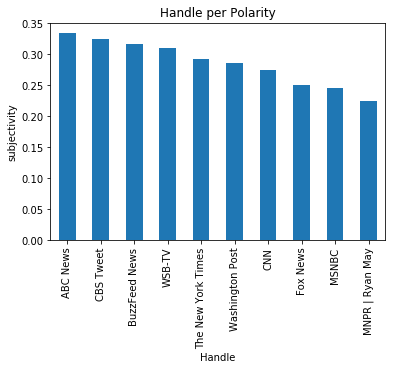

In [37]:
twitter_final2.groupby('handle')['subjectivity'].mean().sort_values(ascending=False).plot(kind='bar',title='Handle per Polarity')
plt.xlabel('Handle')
plt.ylabel('subjectivity');

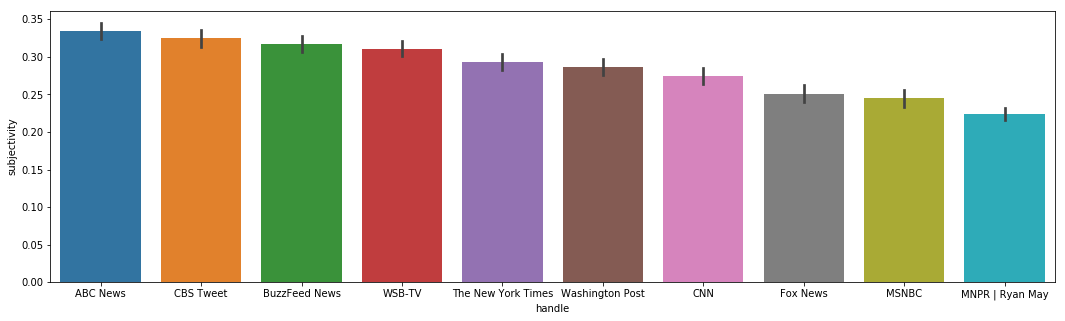

In [39]:
order_of_subjectivity = list(twitter_final2.groupby('handle')['subjectivity'].mean().sort_values(ascending=False).index)
ig, ax = plt.subplots(figsize = (18, 5))
sns.barplot(x = 'handle', y = 'subjectivity',order=order_of_subjectivity, data = twitter_final2, ax = ax)
plt.show()

In [ ]:
# Let check how my defined classes fare in terms of polarity

In [41]:
df_breakfast = twitter_final2.loc[twitter_final2['numeric_time']==1,:]
df_lunch =  twitter_final2.loc[twitter_final2['numeric_time']==2,:]
df_dinner =  twitter_final2.loc[twitter_final2['numeric_time']==3,:]

In [42]:
dic = {
 'breakfast': list(df_breakfast.iloc[:2000,:].loc[:,'polarity']),
 'lunch' : list(df_lunch.iloc[:2000,:].loc[:,'polarity']),
 'dinner': list(df_dinner.iloc[:2000,:].loc[:,'polarity'])
}

In [43]:
classes = pd.DataFrame(dic)

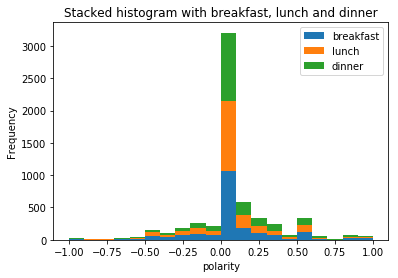

In [44]:
classes[['breakfast','lunch','dinner']].plot.hist(bins=20,stacked=True)
plt.title('Stacked histogram with breakfast, lunch and dinner')
plt.xlabel('polarity')
plt.ylabel('Frequency')

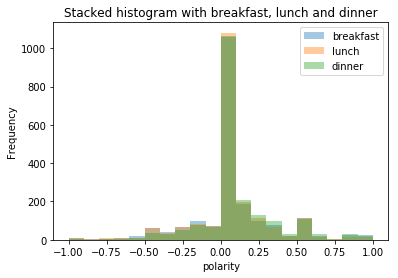

In [45]:
classes[['breakfast','lunch','dinner']].plot.hist(bins=20,alpha=0.4)
plt.title('Stacked histogram with breakfast, lunch and dinner')
plt.xlabel('polarity')
plt.ylabel('Frequency')

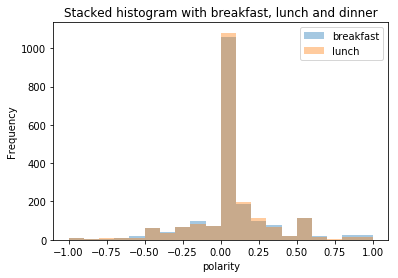

In [46]:
classes[['breakfast','lunch']].plot.hist(bins=20,alpha=0.4)
plt.title('Stacked histogram with breakfast, lunch and dinner')
plt.xlabel('polarity')
plt.ylabel('Frequency')

As we can see it looks like there is not separation between twitter feeds for my different classes

### Build a model with pymc3 to estimate the difference in tone between breakfast and lunchtime tweets

In [ ]:
# The null hypothesis is that there is zero difference between the mean of two groups.
# The alternative hypothesis is that there IS a difference.

# in this MCMC simulation, I will estimate how different  two groups are in terms of polarity

In [48]:
import pymc3 as pm

In [ ]:
# I will be using Bayesian posterior estimation to look at the difference in breakfast_tweets and lunchtime_tweets in 
# terms of polarity

In [50]:
breakfast_tweets_tone= twitter_final2.loc[twitter_final2['numeric_time']==1,'polarity'].values
lunchtime_tweets_tone = twitter_final2.loc[twitter_final2['numeric_time']==2,'polarity'].values

print(breakfast_tweets_tone.mean(),lunchtime_tweets_tone.mean() )

0.0568599118623 0.0509762674637


In [51]:
prior_mean = twitter_final2.polarity.mean()
prior_std = twitter_final2.polarity.std()
print(prior_mean, prior_std)

0.07033627927208666 0.2438994878450581


In [52]:
with pm.Model() as model:
    
    breakfast_tweets_tone_mean = pm.Normal('breakfast_tweets_tone_mean', prior_mean, sd=prior_std)
    lunchtime_tweets_tone_mean = pm.Normal('lunchtime_tweets_tone_mean', prior_mean, sd=prior_std)
    
    breakfast_tweets_tone_std = pm.Gamma('breakfast_tweets_tone_std', mu=prior_std, sd=prior_std)
    lunchtime_tweets_tone_std = pm.Gamma('lunchtime_tweets_tone_std', mu=prior_std, sd=prior_std)
    
    breakfast_tweets_polarity = pm.Normal('breakfast_tweets_polarity', mu=breakfast_tweets_tone_mean, sd=breakfast_tweets_tone_std, observed=breakfast_tweets_tone)
    lunchtime_tweets_polarity = pm.Normal('lunchtime_tweets_polarity', mu=lunchtime_tweets_tone_mean, sd=lunchtime_tweets_tone_std, observed=lunchtime_tweets_tone)
    
    mean_delta = pm.Deterministic('mean_delta', breakfast_tweets_tone_mean - lunchtime_tweets_tone_mean)
    std_delta = pm.Deterministic('std_delta',  breakfast_tweets_tone_std - lunchtime_tweets_tone_std)
    effect_size = pm.Deterministic('effect_size', mean_delta / np.sqrt((breakfast_tweets_tone_std**2 + lunchtime_tweets_tone_std**2)/2.))

In [53]:
with model:
    step = pm.NUTS()
    start = pm.find_MAP()
    trace = pm.sample(50000, start=start, step=step, njobs=2)

logp = -189.36, ||grad|| = 0.040577: 100%|██████████| 13/13 [00:00<00:00, 18.78it/s]  
100%|██████████| 50500/50500 [01:07<00:00, 746.06it/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c163c9630>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1c1fcbb0b8>], dtype=object)

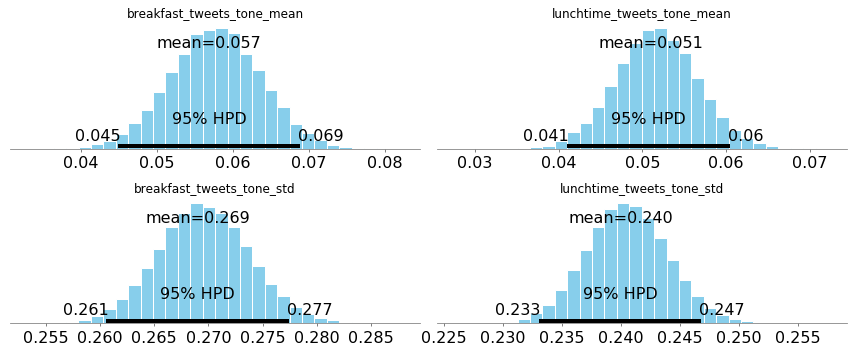

In [54]:
pm.plot_posterior(trace[5000::3],
                  varnames=['breakfast_tweets_tone_mean', 'lunchtime_tweets_tone_mean',
                            'breakfast_tweets_tone_std', 'lunchtime_tweets_tone_std'],
                  color='#87ceeb')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a12d32588>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1a11b72c88>], dtype=object)

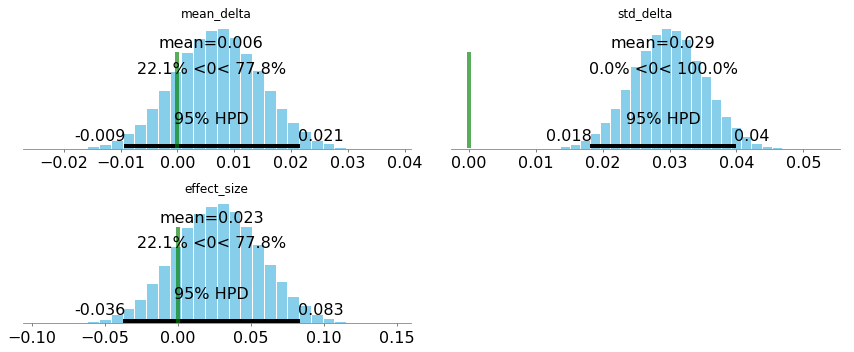

In [55]:
pm.plot_posterior(trace[5000::3],
                  varnames=['mean_delta','std_delta','effect_size'],
                  color='#87ceeb', ref_val=0)

In [ ]:
# The Plot of the posteriors of our metric distributions shows that there is NOT A difference in the mean, therefore the
# the two groups are the same 

### Build a model with pymc3 to estimate the difference in tone between breakfast and dinnertime tweets

In [56]:
breakfast_tweets_tone= twitter_final2.loc[twitter_final2['numeric_time']==1,'polarity'].values
dinnertime_tweets_tone = twitter_final2.loc[twitter_final2['numeric_time']==3,'polarity'].values

print(breakfast_tweets_tone.mean(),dinnertime_tweets_tone.mean() )

0.0568599118623 0.0987745647471


In [57]:
prior_mean2 = twitter_final2.polarity.mean()
prior_std2 = twitter_final2.polarity.std()
print(prior_mean2, prior_std2)

0.07033627927208666 0.2438994878450581


In [58]:
with pm.Model() as model:
    
    breakfast_tweets_tone_mean = pm.Normal('breakfast_tweets_tone_mean', prior_mean2, sd=prior_std2)
    dinnertime_tweets_tone_mean = pm.Normal('dinnertime_tweets_tone_mean', prior_mean2, sd=prior_std2)
    
    breakfast_tweets_tone_std = pm.Gamma('breakfast_tweets_tone_std', mu=prior_std2, sd=prior_std2)
    dinnertime_tweets_tone_std = pm.Gamma('dinnertime_tweets_tone_std', mu=prior_std2, sd=prior_std2)
    
    breakfast_tweets_polarity = pm.Normal('breakfast_tweets_polarity', mu=breakfast_tweets_tone_mean, sd=breakfast_tweets_tone_std, observed=breakfast_tweets_tone)
    dinnertime_tweets_polarity = pm.Normal('dinnertime_tweets_polarity', mu=dinnertime_tweets_tone_mean, sd=dinnertime_tweets_tone_std, observed=dinnertime_tweets_tone)
    
    mean_delta = pm.Deterministic('mean_delta', breakfast_tweets_tone_mean - dinnertime_tweets_tone_mean)
    std_delta = pm.Deterministic('std_delta',  breakfast_tweets_tone_std - dinnertime_tweets_tone_std)
    effect_size = pm.Deterministic('effect_size', mean_delta / np.sqrt((breakfast_tweets_tone_std**2 + dinnertime_tweets_tone_std**2)/2.))

In [59]:
with model:
    step = pm.NUTS()
    start = pm.find_MAP()
    trace = pm.sample(50000, start=start, step=step, njobs=2)

logp = -161.94, ||grad|| = 0.040496: 100%|██████████| 13/13 [00:00<00:00, 670.14it/s]  
100%|██████████| 50500/50500 [01:23<00:00, 608.32it/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c2168a2b0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1c1676f9b0>], dtype=object)

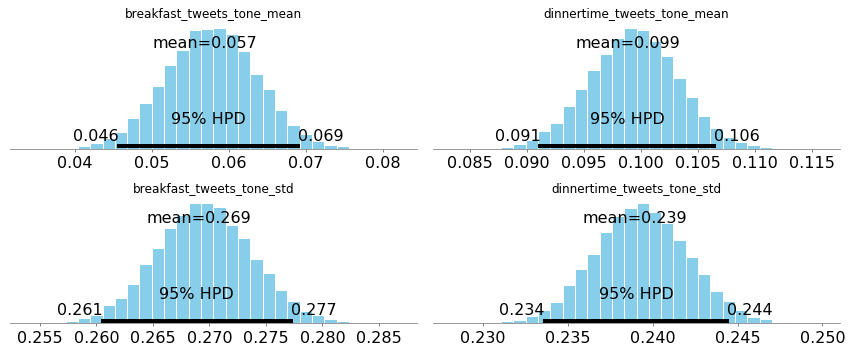

In [60]:
pm.plot_posterior(trace[5000::3],
                  varnames=['breakfast_tweets_tone_mean', 'dinnertime_tweets_tone_mean',
                            'breakfast_tweets_tone_std', 'dinnertime_tweets_tone_std'],
                  color='#87ceeb')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c2107df60>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1c1f6b3668>], dtype=object)

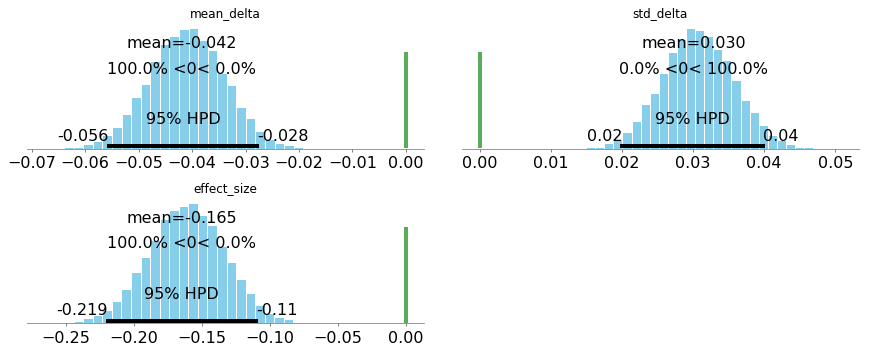

In [61]:
pm.plot_posterior(trace[5000::3],
                  varnames=['mean_delta','std_delta','effect_size'],
                  color='#87ceeb', ref_val=0)

In [ ]:
# The Plot of the posteriors of our metric distributions shows that there is A difference in the mean, therefore the
# two groups are different

### Build a model with pymc3 to estimate the difference in tone between lunchtime and dinnertime tweets

In [63]:
lunchtime_tweets_tone= twitter_final2.loc[twitter_final2['numeric_time']==2,'polarity'].values
dinnertime_tweets_tone = twitter_final2.loc[twitter_final2['numeric_time']==3,'polarity'].values

print(lunchtime_tweets_tone.mean(),dinnertime_tweets_tone.mean() )

0.0509762674637 0.0987745647471


In [64]:
prior_mean3 = twitter_final2.polarity.mean()
prior_std3 = twitter_final2.polarity.std()
print(prior_mean3, prior_std3)

0.07033627927208666 0.2438994878450581


In [65]:
with pm.Model() as model:
    
    lunchtime_tweets_tone_mean = pm.Normal('lunchtime_tweets_tone_mean', prior_mean3, sd=prior_std3)
    dinnertime_tweets_tone_mean = pm.Normal('dinnertime_tweets_tone_mean', prior_mean3, sd=prior_std3)
    
    lunchtime_tweets_tone_std = pm.Gamma('lunchtime_tweets_tone_std', mu=prior_std3, sd=prior_std3)
    dinnertime_tweets_tone_std = pm.Gamma('dinnertime_tweets_tone_std', mu=prior_std3, sd=prior_std3)
    
    lunchtime_tweets_polarity = pm.Normal('lunchtime_tweets_polarity', mu=lunchtime_tweets_tone_mean, sd=lunchtime_tweets_tone_std, observed=lunchtime_tweets_tone)
    dinnertime_tweets_polarity = pm.Normal('dinnertime_tweets_polarity', mu=dinnertime_tweets_tone_mean, sd=dinnertime_tweets_tone_std, observed=dinnertime_tweets_tone)
    
    mean_delta = pm.Deterministic('mean_delta', lunchtime_tweets_tone_mean - dinnertime_tweets_tone_mean)
    std_delta = pm.Deterministic('std_delta',  lunchtime_tweets_tone_std - dinnertime_tweets_tone_std)
    effect_size = pm.Deterministic('effect_size', mean_delta / np.sqrt((lunchtime_tweets_tone_std**2 + dinnertime_tweets_tone_std**2)/2.))

In [66]:
with model:
    step = pm.NUTS()
    start = pm.find_MAP()
    trace = pm.sample(50000, start=start, step=step, njobs=2)

logp = 71.707, ||grad|| = 0.15606: 100%|██████████| 14/14 [00:00<00:00, 870.38it/s]  
100%|██████████| 50500/50500 [01:18<00:00, 642.18it/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c217175c0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1c21b81d30>], dtype=object)

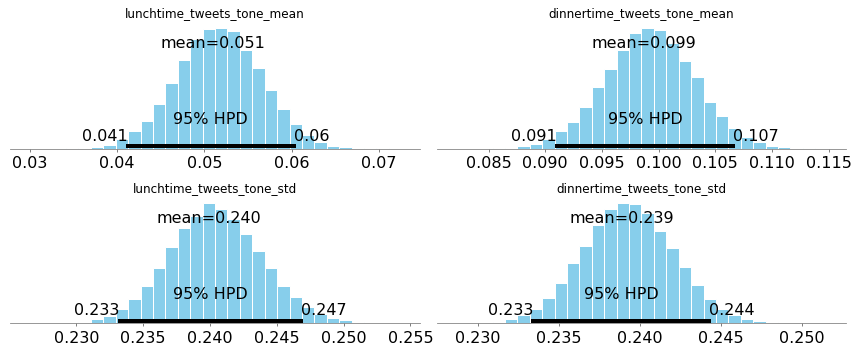

In [67]:
pm.plot_posterior(trace[5000::3],
                  varnames=['lunchtime_tweets_tone_mean', 'dinnertime_tweets_tone_mean',
                            'lunchtime_tweets_tone_std', 'dinnertime_tweets_tone_std'],
                  color='#87ceeb')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c21b3e6a0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1c21af9da0>], dtype=object)

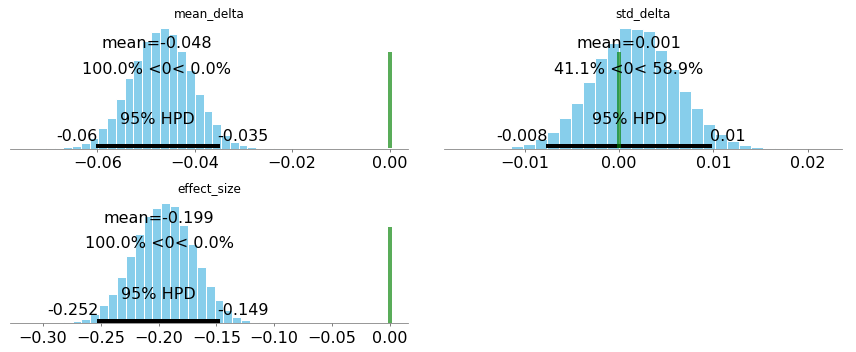

In [68]:
pm.plot_posterior(trace[5000::3],
                  varnames=['mean_delta','std_delta','effect_size'],
                  color='#87ceeb', ref_val=0)

In [ ]:
# The Plot of the posteriors of our metric distributions shows that there is A difference in the mean, therefore the
# two groups are different

In [69]:
pm.summary(trace[5000:],varnames=['mean_delta','std_delta','effect_size'])


mean_delta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.048           0.006            0.000            [-0.060, -0.035]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.060         -0.052         -0.048         -0.044         -0.036


std_delta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.001            0.004            0.000            [-0.007, 0.010]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.008         -0.002         0.001          0.004          0.010


effect_size:

  Mean             SD               MC Error         95% HPD interval
  ------

In [74]:
twitter_final3 = twitter_final2.copy()

In [75]:
twitter_final3.drop_duplicates('Text').shape

(26930, 12)

In [76]:
twitter_final3=twitter_final3.drop_duplicates('Text')

In [78]:
twitter_final3 = twitter_final3.dropna()

In [80]:
twitter_final3.shape

(6740, 12)

### Use LDA to identify topics in the tweets

In [70]:
from sklearn.decomposition import LatentDirichletAllocation

In [79]:
cv = CountVectorizer(stop_words='english')
cv.fit(twitter_final3['Text'].values)
X = cv.transform(twitter_final3['Text'].values)
X

<6740x12979 sparse matrix of type '<class 'numpy.int64'>'
	with 59237 stored elements in Compressed Sparse Row format>

In [81]:
feature_names = cv.get_feature_names()
lda = LatentDirichletAllocation(n_components=10)

lda.fit(X)

//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:532: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

In [82]:
print(lda.components_.shape)

(10, 12979)


In [83]:
results = pd.DataFrame(lda.components_,
                      columns=feature_names)

In [84]:
for topic in range(10):
    print('Topic', topic)
    word_list = results.T[topic].sort_values(ascending=False).index
    print(' '.join(word_list[0:25]), '\n')

Topic 0
new heres dont people live york know years christmas black train said washington series im best official amtrak city report killed early tv high miss 

Topic 1
latest marketing mnpr ryan sexual media harassment women social north paul amp manager power think korea misconduct news accused congress friday campaign breaking net neutrality 

Topic 2
thanks daily police hire say man year want digital school people atlanta attack monday open matt dead shooting woman lauer airport stop arrested center shot 

Topic 3
gop happy russia times south new prince say person hiring charged lot missile harry obama technology update meghan according florida men sneak authority expected bus 

Topic 4
trump president tax says house time white analysis trumps watch pres republicans jerusalem pr senate world sen deal got russian vote republican plan news come 

Topic 5
job relations roy moore cbs alabama week trump allegations intern american senate season says president going theres people hes comp

The topics talked sexual harassment, russia investigation, and election

### Multiclass Classification Model Building

In [85]:
df_breakfast = twitter_final2.loc[twitter_final2['numeric_time']==1,:]
df_lunch = twitter_final2.loc[twitter_final2['numeric_time']==2,:]
df_dinner =  twitter_final2.loc[twitter_final2['numeric_time']==3,:]

In [86]:
twitter_final2.Text.isnull().sum()

40

In [87]:
model_df =twitter_final2.loc[twitter_final2['numeric_time'] !=4,:]

In [88]:
model_df = model_df.dropna()

In [89]:
X = model_df['Text']
y= model_df['numeric_time']

In [118]:
# the baseline
y_test.value_counts()/len(y_test)

3    0.458049
2    0.282439
1    0.259512
Name: numeric_time, dtype: float64

In [265]:
scoring_dict = {}

### Naive bayes models

In [287]:
from sklearn.naive_bayes import MultinomialNB
X_train,X_test, y_train,y_test = train_test_split(X, y,random_state=2017)
tfidf = TfidfVectorizer()

X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

mnb = MultinomialNB()
mnb.fit(X_train,y_train)


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [288]:
df_X_train = pd.DataFrame(X_train.todense(), columns=tfidf.get_feature_names())

In [289]:
ypreds = mnb.predict(X_test)

In [290]:
conmat_1 = confusion_matrix(y_test, ypreds, labels=mnb.classes_)
conmat_1 = pd.DataFrame(conmat_1, columns=mnb.classes_, index=mnb.classes_)
print(accuracy_score(y_test,ypreds))
scoring_dict['Naive Bayes Accuracy'] = float(accuracy_score(y_test,ypreds))
print(classification_report(y_test,ypreds))
print( conmat_1)

0.519512195122
             precision    recall  f1-score   support

          1       0.43      0.09      0.15       532
          2       0.51      0.34      0.41       579
          3       0.53      0.87      0.66       939

avg / total       0.50      0.52      0.46      2050

    1    2    3
1  50  106  376
2  29  197  353
3  37   84  818


In [291]:
# Naive bayes using ngram_range = 2,4
from sklearn.naive_bayes import MultinomialNB
X_train,X_test, y_train,y_test = train_test_split(X, y,random_state=2017)
tfidf = TfidfVectorizer(ngram_range=(2,4))

X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

mnb = MultinomialNB()
mnb.fit(X_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [292]:
ypreds = mnb.predict(X_test)
conmat_1 = confusion_matrix(y_test, ypreds, labels=mnb.classes_)
conmat_1 = pd.DataFrame(conmat_1, columns=mnb.classes_, index=mnb.classes_)
print(accuracy_score(y_test,ypreds))
scoring_dict['Naive Bayes Accuracy_2_4'] = float(accuracy_score(y_test,ypreds))
print(classification_report(y_test,ypreds))
print( conmat_1)

0.51512195122
             precision    recall  f1-score   support

          1       0.40      0.06      0.11       532
          2       0.60      0.28      0.38       579
          3       0.51      0.91      0.65       939

avg / total       0.51      0.52      0.44      2050

    1    2    3
1  34   61  437
2  19  163  397
3  31   49  859


### Support Vector Machine

In [293]:
from sklearn.svm import SVC

In [294]:
from sklearn.svm import SVC
X_train,X_test, y_train,y_test = train_test_split(X, y,random_state=2019)
tfidf = TfidfVectorizer()

X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

svc = SVC(class_weight='balanced', C=.01, kernel='linear')
svc.fit(X_train,y_train)

SVC(C=0.01, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [295]:
ypreds = svc.predict(X_test)
conmat_1 = confusion_matrix(y_test, ypreds, labels=svc.classes_)
conmat_1 = pd.DataFrame(conmat_1, columns=svc.classes_, index=svc.classes_)
print(accuracy_score(y_test,ypreds))
scoring_dict['Support Vector Machine'] = float(accuracy_score(y_test,ypreds))
print(classification_report(y_test,ypreds))
print( conmat_1)

0.358048780488
             precision    recall  f1-score   support

          1       0.00      0.00      0.00       502
          2       0.32      1.00      0.49       626
          3       1.00      0.12      0.21       922

avg / total       0.55      0.36      0.24      2050

   1    2    3
1  0  502    0
2  0  626    0
3  0  814  108


//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


This model does not give us any signal. It randomly predicts one class or another  

### Gradient Boosting model

In [296]:
X_train,X_test, y_train,y_test = train_test_split(X, y,random_state=2019)
tfidf = TfidfVectorizer()
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

gb =GradientBoostingClassifier()
gb.fit(X_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [297]:
ypreds = gb.predict(X_test)
conmat_1 = confusion_matrix(y_test, ypreds, labels=gb.classes_)
conmat_1 = pd.DataFrame(conmat_1, columns=gb.classes_, index=gb.classes_)
print(accuracy_score(y_test,ypreds))
scoring_dict['Gradient Boosting model'] = float(accuracy_score(y_test,ypreds))
print(classification_report(y_test,ypreds))
print( conmat_1)

0.52
             precision    recall  f1-score   support

          1       0.57      0.08      0.14       502
          2       0.72      0.24      0.37       626
          3       0.49      0.95      0.65       922

avg / total       0.58      0.52      0.44      2050

    1    2    3
1  40   22  440
2  18  153  455
3  12   37  873


### Adaboost model

In [298]:
X_train,X_test, y_train,y_test = train_test_split(X, y,random_state=2019)
tfidf = TfidfVectorizer()
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

ada =AdaBoostClassifier()
ada.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [299]:
ypreds = ada.predict(X_test)
conmat_1 = confusion_matrix(y_test, ypreds, labels=ada.classes_)
conmat_1 = pd.DataFrame(conmat_1, columns=ada.classes_, index=ada.classes_)
print(accuracy_score(y_test,ypreds))
scoring_dict['Adaboost model'] = float(accuracy_score(y_test,ypreds))
print(classification_report(y_test,ypreds))
print( conmat_1)

0.506829268293
             precision    recall  f1-score   support

          1       0.46      0.04      0.08       502
          2       0.68      0.24      0.35       626
          3       0.49      0.94      0.64       922

avg / total       0.54      0.51      0.42      2050

    1    2    3
1  21   26  455
2  15  150  461
3  10   44  868


### Random Forest models

In [300]:
tfidf = TfidfVectorizer()
rf = RandomForestClassifier()
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [301]:
ypreds = rf.predict(X_test)
conmat_1 = confusion_matrix(y_test, ypreds, labels=rf.classes_)
conmat_1 = pd.DataFrame(conmat_1, columns=rf.classes_, index=rf.classes_)
print(accuracy_score(y_test,ypreds))
scoring_dict['Random Forest models'] = float(accuracy_score(y_test,ypreds))
print(classification_report(y_test,ypreds))
print( conmat_1)

0.480487804878
             precision    recall  f1-score   support

          1       0.32      0.23      0.27       502
          2       0.47      0.37      0.42       626
          3       0.53      0.69      0.60       922

avg / total       0.46      0.48      0.46      2050

     1    2    3
1  115  112  275
2  114  234  278
3  136  150  636


In [302]:
# MOST PREDICTIVE WORDS USING ngram 1,1
X_train,X_test, y_train,y_test = train_test_split(X, y,random_state=2017)
tfidf = TfidfVectorizer(ngram_range=(1,1))

X_train1 = tfidf.fit_transform(X_train)
X_test1 = tfidf.transform(X_test)

rf = RandomForestClassifier()
rf.fit(X_train1,y_train)

df_X_train1 = pd.DataFrame(X_train1.todense(), columns=tfidf.get_feature_names())

#MOST PREDICTIVE WORDS
coes1 = pd.DataFrame(rf.feature_importances_, index =df_X_train1.columns,columns=['Coeffs'])

word_ind1 = coes1.sort_values('Coeffs', ascending=False)[:100]
word_ind1

,Coeffs
mnpr,0.012932
thanks,0.010943
daily,0.010386
relations,0.007332
minnesota,0.007234
blog,0.005274
job,0.004684
latest,0.004268
trump,0.003764
new,0.002899


### finding the most predictive words using ngram_range 1,2

In [303]:
# MOST PREDICTIVE WORDS USING ngram 1,2
X_train,X_test, y_train,y_test = train_test_split(X, y,random_state=2017)
tfidf2 = TfidfVectorizer(ngram_range=(1,2))

X_train2 = tfidf2.fit_transform(X_train)
X_test2 = tfidf2.transform(X_test)

rf2 = RandomForestClassifier()
rf2.fit(X_train2,y_train)

df_X_train2 = pd.DataFrame(X_train2.todense(), columns=tfidf2.get_feature_names())

#MOST PREDICTIVE WORDS
coes2 = pd.DataFrame(rf2.feature_importances_, index =df_X_train2.columns,columns=['Coeffs'])

word_ind2 = coes2.sort_values('Coeffs', ascending=False)[:100]
word_ind2

,Coeffs
ryan,0.011110
via minnesota,0.008427
minnesota,0.008170
mnpr,0.007393
latest mnpr,0.005076
relations blog,0.004311
ryan may,0.003429
mnpr ryan,0.003311
marketing,0.002768
cbs,0.002405


In [249]:
# Model evaluation using ngram = 1,2

In [304]:
ypreds = rf2.predict(X_test2)
conmat_1 = confusion_matrix(y_test, ypreds, labels=rf2.classes_)
conmat_1 = pd.DataFrame(conmat_1, columns=rf2.classes_, index=rf2.classes_)
print(accuracy_score(y_test,ypreds))
scoring_dict['Random Forest models_1_2'] = float(accuracy_score(y_test,ypreds))
print(classification_report(y_test,ypreds))
print( conmat_1)

0.504390243902
             precision    recall  f1-score   support

          1       0.40      0.30      0.34       532
          2       0.45      0.45      0.45       579
          3       0.58      0.66      0.61       939

avg / total       0.49      0.50      0.50      2050

     1    2    3
1  160  138  234
2  100  258  221
3  141  182  616


### finding the most predictive words using ngram_range 2,2

In [305]:
# PREDICTIVE WORDS FOR ngram_range = 2,2
X_train,X_test, y_train,y_test = train_test_split(X, y,random_state=2017)
tfidf3 = TfidfVectorizer(ngram_range=(2,2))

X_train3 = tfidf3.fit_transform(X_train)
X_test3 = tfidf3.transform(X_test)

rf3 = RandomForestClassifier()
rf3.fit(X_train3,y_train)

df_X_train3 = pd.DataFrame(X_train3.todense(), columns=tfidf3.get_feature_names())

#MOST PREDICTIVE WORDS
coes3 = pd.DataFrame(rf3.feature_importances_, index =df_X_train3.columns,columns=['Coeffs'])

word_ind3 = coes3.sort_values('Coeffs', ascending=False)[:100]
word_ind3

,Coeffs
daily thanks,0.008956
via minnesota,0.007954
may daily,0.007305
mnpr ryan,0.007146
ryan may,0.006460
public relations,0.005790
relations blog,0.003585
minnesota public,0.003006
public mnpr,0.002417
seeks hire,0.002125


In [252]:
# Model evaluation using ngram 2,2

In [306]:
ypreds = rf3.predict(X_test3)
conmat_1 = confusion_matrix(y_test, ypreds, labels=rf3.classes_)
conmat_1 = pd.DataFrame(conmat_1, columns=rf3.classes_, index=rf3.classes_)
print(accuracy_score(y_test,ypreds))
scoring_dict['Random Forest models_2_2'] = float(accuracy_score(y_test,ypreds))
print(classification_report(y_test,ypreds))
print( conmat_1)

0.461951219512
             precision    recall  f1-score   support

          1       0.33      0.55      0.41       532
          2       0.47      0.36      0.41       579
          3       0.62      0.47      0.54       939

avg / total       0.50      0.46      0.47      2050

     1    2    3
1  295  114  123
2  222  209  148
3  374  122  443


###  Logistic Regression

In [307]:
X_train,X_test, y_train,y_test = train_test_split(X, y,random_state=2017)
tfidf = TfidfVectorizer(ngram_range=(2,2))

X_train1 = tfidf.fit_transform(X_train)
X_test1 = tfidf.transform(X_test)

lr = LogisticRegression()
lr.fit(X_train1,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [308]:
ypreds = lr.predict(X_test1)
conmat_1 = confusion_matrix(y_test, ypreds, labels=lr.classes_)
conmat_1 = pd.DataFrame(conmat_1, columns=lr.classes_, index=lr.classes_)
print(accuracy_score(y_test,ypreds))
scoring_dict['Logistic Regression'] = float(accuracy_score(y_test,ypreds))
print(classification_report(y_test,ypreds))
print( conmat_1)

0.513658536585
             precision    recall  f1-score   support

          1       0.37      0.07      0.12       532
          2       0.56      0.30      0.39       579
          3       0.51      0.90      0.65       939

avg / total       0.49      0.51      0.44      2050

    1    2    3
1  38   73  421
2  30  173  376
3  36   61  842


In [309]:
pd.DataFrame(lr.coef_,columns= tfidf.get_feature_names(), index=['Breakfast', 'Lunch', 'Dinner']).T.sort_values(by='Dinner')

,Breakfast,Lunch,Dinner
via minnesota,-2.404740,4.227352,-2.888136
minnesota public,-2.118150,3.291181,-2.174884
public relations,-1.911889,3.085704,-2.098783
matt lauer,-0.275926,1.720166,-1.461177
police say,0.819517,0.565238,-1.357091
relations blog,-1.291757,1.899286,-1.305269
port authority,-0.363520,1.492007,-1.212523
public mnpr,-0.742973,1.599786,-1.125761
climate change,0.677455,0.447955,-1.066707
heres need,-0.398049,1.140580,-0.923689


###  Neural Networks using Keras

In [141]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.
//anaconda/envs/py36/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [310]:
X_train,X_test, y_train,y_test = train_test_split(X, y,random_state=2017)
tfidf = TfidfVectorizer(ngram_range=(1,1))

X_train = tfidf.fit_transform(X_train) #sparse matrix
X_test = tfidf.transform(X_test)
y_train = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

X_train = X_train.todense() # transform back to regular numpy array
X_test = X_test.todense()

In [311]:
#pd.DataFrame(X_train.todense(), columns=tfidf.get_feature_names())

In [312]:
model = Sequential()
model.add(Dense(10, input_dim=X_train.shape[1],activation='relu'))
model.add(Dropout(.5))
model.add(Dense(5, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test_cat), epochs=20, batch_size=70)

Train on 6150 samples, validate on 2050 samples
Epoch 1/20
6150/6150 [==============================] - 3s 456us/step - loss: 1.3465 - acc: 0.4476 - val_loss: 1.2892 - val_acc: 0.4580
Epoch 2/20
6150/6150 [==============================] - 1s 241us/step - loss: 1.2278 - acc: 0.4642 - val_loss: 1.1535 - val_acc: 0.4854
Epoch 3/20
6150/6150 [==============================] - 1s 229us/step - loss: 1.1055 - acc: 0.4875 - val_loss: 1.0616 - val_acc: 0.4980
Epoch 4/20
6150/6150 [==============================] - 1s 233us/step - loss: 1.0145 - acc: 0.5285 - val_loss: 1.0035 - val_acc: 0.5102
Epoch 5/20
6150/6150 [==============================] - 1s 242us/step - loss: 0.9286 - acc: 0.5865 - val_loss: 0.9754 - val_acc: 0.5117
Epoch 6/20
6150/6150 [==============================] - 1s 234us/step - loss: 0.8583 - acc: 0.6184 - val_loss: 0.9723 - val_acc: 0.5000
Epoch 7/20
6150/6150 [==============================] - 1s 232us/step - loss: 0.7982 - acc: 0.6433 - val_loss: 0.9736 - val_acc: 0.5073


In [211]:
#preds = model.predict_classes(X_test)


In [212]:
#accuracy_score(y_test,preds)

In [213]:
#confusion_matrix(y_test, preds)

In [214]:
ypreds

array([3, 3, 3, ..., 3, 2, 3])

In [313]:
ypreds = model.predict_classes(X_test)
conmat_1 = confusion_matrix(y_test, ypreds, labels=[1,2,3])
conmat_1 = pd.DataFrame(conmat_1, columns=[1,2,3], index=[1,2,3])
print(accuracy_score(y_test,ypreds))
scoring_dict['Neural Networks Keras'] = float(accuracy_score(y_test,ypreds))
print(classification_report(y_test,ypreds))
print( conmat_1)

0.496097560976
             precision    recall  f1-score   support

          1       0.35      0.35      0.35       532
          2       0.44      0.46      0.45       579
          3       0.62      0.60      0.61       939

avg / total       0.50      0.50      0.50      2050

     1    2    3
1  188  171  173
2  141  267  171
3  203  174  562


In [225]:
scoring_dict

{'Adaboost model': 0.50682926829268293,
 'Gradient Boosting model': 0.51804878048780489,
 'Logistic Regression': 0.51365853658536587,
 'Naive Bayes Accuracy': 0.51951219512195124,
 'Naive Bayes Accuracy_2_4': 0.51512195121951221,
 'Neural Networks Keras': 0.51560975609756099,
 'Random Forest models': 0.49414634146341463,
 'Random Forest models_1_2': 0.50536585365853659,
 'Random Forest models_2_2': 0.50926829268292684,
 'Support Vector Machine': 0.35804878048780486}

In [233]:
scoring_dict = scoring_dict2 

In [324]:
Model = pd.DataFrame(data=list(scoring_dict.values()), index=list(scoring_dict.keys()))

In [339]:
#Model.sort_values(by=0, ascending=False).plot(kind='bar', legend=False)

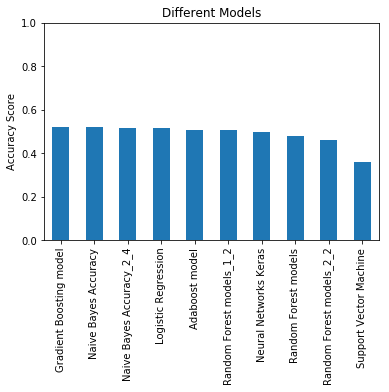

In [338]:

ax = Model.sort_values(by=0, ascending=False).plot(kind='bar', legend=False)

ax.set_ylim(top=1)
ax.set_title('Different Models') 
ax.set_ylabel('Accuracy Score')

Because the there is no separation of the classes, We noticed that the models are mostly similar